# Galaxy Classification with CNN (Pytorch)

Data:

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge



References:

1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

2. https://pytorch.org/vision/stable/models.html

3. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

4. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

5. https://cs231n.github.io/transfer-learning/



## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-bd5660d7-3596-8c81-3c8a-0940bad7ecf3)


## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Unzip images

Before running the code, please upload `images_train.zip`, `images_valid.zip` and `images_test.zip` to the workspace.

We upzip these 3 files, and place"

- all training images (n=39,410) into the folder `images_train`
- all validation images (n=9,852) into the folder `images_valid`, and
- all test images (n=12,316) into the folder `images_test`.

We create the folders first if they don't exist.

In [3]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

In [4]:
## Unzip training, validation, and test images
unzipping('images_train.zip', 'images_train')
unzipping('images_valid.zip', 'images_valid')
unzipping('images_test.zip', 'images_test')

## Import custom datasets

In [5]:
## Custom Galaxy Zoo Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label

## Data Augmentation Transforms

In [6]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0, 0, 0], [255, 255, 255]),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0, 0, 0], [255, 255, 255]),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])  

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0, 0, 0], [255, 255, 255]),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    
    return train_transform, valid_transform, test_transform

## Parameters

In [7]:
NUM_OF_CLASSES = 5  # there are 5 classes in total
BATCH_SIZE = 32     # batch zize

## Training function

In [8]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10, is_for_inception=False):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
        is_for_inception: True if the model is an inception model
    """
    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    # best valid acc
    best_valid_acc = 0.0
    # best epoch
    best_epoch = -1    

    # intiate dict to records the history of loss and acc
    history_dic = dict()
    history_dic['train_loss'] = []
    history_dic['train_acc'] = []
    history_dic['valid_loss'] = []
    history_dic['valid_acc'] = []
    history_dic['lr'] = []

    for epoch in range(num_epochs):
        # time of start
        epoch_start_time = time.time()

        """
        Train
        """
        model.train()

        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            
            if is_for_inception:
                pred_logits, aux_outputs = model(images)
                loss = criterion(pred_logits, labels) + 0.4*criterion(aux_outputs, labels)
            else:
                pred_logits = model(images)
                loss = criterion(pred_logits, labels)

            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            pred_classes = pred_classes.long()

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes==labels.data)

            loss.backward()
            optimizer.step()
            
        """
        Eval
        """
        model.eval()

        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                pred_logits = model(images)
                _, pred_classes = torch.max(pred_logits.detach(), dim=1)
                loss = criterion(pred_logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes==labels.data)

        ## Calculate metrics
        train_loss = epoch_train_cum_loss / len(data_train)
        train_acc = epoch_train_cum_corrects / len(data_train)
        valid_loss = epoch_valid_cum_loss / len(data_valid)
        valid_acc = epoch_valid_cum_corrects / len(data_valid)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            # update the best model weights
            best_model_weights = deepcopy(model.state_dict())

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        # convert epoch_time_used into mm:ss
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        ## Print metrics
        if (epoch+1) % print_every == 0:
            print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tlr={}\tTime: {:.0f}m {:.0f}s".format(
                epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, scheduler.get_last_lr()[0], mm, ss))
            
        ## Early stopping
        if (epoch+1) - best_epoch >= early_stop_epochs:
            print("Early stopping... (Model did not improve after {} epochs)".format(early_stop_epochs))
            break
        
        scheduler.step()
    
    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    # print the best epoch
    print("Best epoch = {}, with acc = {:.3f}".format(best_epoch, best_valid_acc))
    # return the best model
    return model, history_dic

## ResNet50 Model

### Model architecture

In [9]:
## Resnet50 architecture
model = models.resnet50(pretrained=True)
print(model)
# count trainable parameters
print("==========")
print("Number of trainable parameters:")
print("layer1: {}".format(sum(param.numel() for param in model.layer1.parameters() if param.requires_grad)))
print("layer2: {}".format(sum(param.numel() for param in model.layer2.parameters() if param.requires_grad)))
print("layer3: {}".format(sum(param.numel() for param in model.layer3.parameters() if param.requires_grad)))
print("layer4: {}".format(sum(param.numel() for param in model.layer4.parameters() if param.requires_grad)))
print("fc: {}".format(sum(param.numel() for param in model.fc.parameters() if param.requires_grad)))
print("TOTAL: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("==========")
# free the space
del model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Create transforms and dataloaders

We set `is_for_inception` to `False`

In [12]:
# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('labels_train.csv', 'images_train', train_transform)
data_valid = GalaxyZooDataset('labels_valid.csv', 'images_valid', valid_transform)
data_test = GalaxyZooDataset('labels_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))

Number of training data: 39410 (1232 batches)
Number of validation data: 9852 (308 batches)
Number of test data: 12316 (385 batches)


### Train

In [13]:
## Download the pre-trained resnet50 model
model = models.resnet50(pretrained=True)

# change the last fc layer
model.fc = nn.Linear(2048, NUM_OF_CLASSES)
print(model.fc) # print the modified last layer

print("============")
print("Training")
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("============")

# move to gpu
model = model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5)
# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## train and return the best model
model, history_dic = train_model(model, 50, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10, is_for_inception=False)

# filename to save
filename_prefix = "resnet50_trained_b32_lr000005_ss10_gamma01_E50_e{}".format(len(history_dic['valid_acc']))

## Save the best weights
torch.save(model.state_dict(), filename_prefix + ".pth")

## Convert history to dataframe
df = pd.DataFrame(history_dic)

## Save the history
df.to_csv(filename_prefix + ".csv")

Linear(in_features=2048, out_features=5, bias=True)
Training
Number of trainable parameters: 23518277
Epoch 1/50	Train loss: 0.6526	Train acc: 0.7471	Valid loss: 2.3281	Valid acc: 0.2256	lr=5e-05	Time: 7m 20s
Epoch 2/50	Train loss: 0.5595	Train acc: 0.7790	Valid loss: 1.2612	Valid acc: 0.4283	lr=5e-05	Time: 7m 20s
Epoch 3/50	Train loss: 0.5323	Train acc: 0.7890	Valid loss: 0.8433	Valid acc: 0.6854	lr=5e-05	Time: 7m 20s
Epoch 4/50	Train loss: 0.5184	Train acc: 0.7937	Valid loss: 0.7717	Valid acc: 0.7257	lr=5e-05	Time: 7m 20s
Epoch 5/50	Train loss: 0.5031	Train acc: 0.7999	Valid loss: 1.2680	Valid acc: 0.5754	lr=5e-05	Time: 7m 20s
Epoch 6/50	Train loss: 0.4948	Train acc: 0.8020	Valid loss: 0.5816	Valid acc: 0.7649	lr=5e-05	Time: 7m 24s
Epoch 7/50	Train loss: 0.4840	Train acc: 0.8077	Valid loss: 2.6937	Valid acc: 0.1908	lr=5e-05	Time: 7m 20s
Epoch 8/50	Train loss: 0.4774	Train acc: 0.8092	Valid loss: 0.7196	Valid acc: 0.7205	lr=5e-05	Time: 7m 23s
Epoch 9/50	Train loss: 0.4711	Train acc: 0

## Plot History

history_filename: resnet50_trained_b32_lr000005_ss10_gamma01_E50_e33.csv


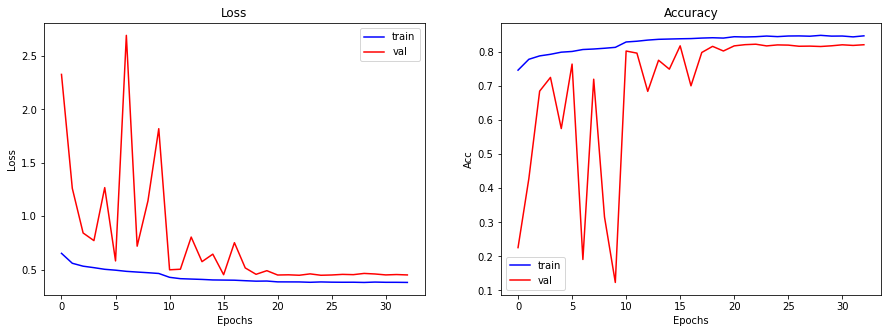

In [26]:
# history filename
history_filename = filename_prefix + ".csv"
print("history_filename: {}".format(history_filename))

# read csv
df = pd.read_csv(history_filename)

# number of epochs
epochs = len(history_dic['valid_acc'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(epochs), history_dic['train_loss'], 'b', label='train')
ax1.plot(range(epochs), history_dic['valid_loss'], 'r', label='val')
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(range(epochs), history_dic['train_acc'], 'b', label='train')
ax2.plot(range(epochs), history_dic['valid_acc'], 'r', label='val')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Acc")
ax2.legend()
plt.show()

## Predict Test Data

In [27]:
# weights filename
weights_filename = filename_prefix + ".pth"
print("weights_filename = {}".format(weights_filename))

# download the pre-trained resnet50 model
model = models.resnet50(pretrained=True)

# change the last fc layer
model.fc = nn.Linear(2048, NUM_OF_CLASSES)

# load the weights
model.load_state_dict(torch.load(weights_filename))

# move to gpu
model = model.to(device)

# evaluation
model.eval()

# loss and accuracy
epoch_test_cum_loss = 0.0
epoch_test_cum_corrects = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.long().to(device)

    with torch.no_grad():
        pred_logits = model(images)
        _, pred_classes = torch.max(pred_logits.detach(), dim=1)
        loss = criterion(pred_logits, labels)

        epoch_test_cum_loss += loss.item() * images.size(0)
        epoch_test_cum_corrects += torch.sum(pred_classes==labels.data)

# calculate final loss and accuracy
test_loss = epoch_test_cum_loss / len(data_test)
test_acc = epoch_test_cum_corrects / len(data_test)

# display
print("Test loss: {:.4f}".format(test_loss))
print("Test accuracy: {:.4f}".format(test_acc))

weights_filename = resnet50_trained_b32_lr000005_ss10_gamma01_E50_e33.pth
Test loss: 0.4316
Test accuracy: 0.8241


## Best model

The current best CNN model is `resnet50_trained_b32_lr000005_ss10_gamma01_E50_e33.pth`, with the test accuracy = **0.8241**